In [1]:
pwd

u'/Users/linzeyang'

In [2]:
cd Desktop/BIA-660/Final Project/data

/Users/linzeyang/Desktop/BIA-660/Final Project/data


In [3]:
import pandas as pd
import numpy as np
import re
import datetime
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from six.moves import urllib
import json
import collections
import itertools
import requests
import time
import pandas as pd
from  __builtin__ import any as b_any
import math
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import glob
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

/Users/linzeyang/anaconda/envs/py2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# glob.glob("2016*.csv")

[]

In [71]:
# glob.glob("../in/sales*.xlsx")
# all_data = pd.DataFrame()
# for f in glob.glob("2016*.csv"):
#     df = pd.read_csv(f)
#     all_data = all_data.append(df,ignore_index=True)

In [78]:
#del all_data['Birth Year']
#del all_data['User Type']
#del all_data['Gender']

## Integrate Variables & Data Preprocess

In [4]:
# =========== Pre-process ==========
df = pd.read_csv('201612-citibike-tripdata.csv')
#df = pd.read_csv('201608-citibike-tripdata.csv')
#df = all_data
# Missing values in columns
#print(df.isnull().sum())
# Snake_case the columns
def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).replace(' ','').lower()
df.columns = [camel_to_snake(col) for col in df.columns]

# Parse start_time and stop_time
try:
    df['start_datetime'] = [datetime.datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in df.start_time]
#except ValueError:
    #df['start_datetime'] = [datetime.datetime.strptime(x, '%m/%d/%Y %H:%M') for x in df.start_time]
except ValueError:
     df['start_datetime'] = [datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df.start_time]
df['start_day'] = [x.strftime('%Y-%m-%d') for x in df.start_datetime]

# =========== Group by date and station ===========
df['bikein'] = 1
df['bikeout'] = 1

df_bikeout = df.groupby(by=['start_stationid', 'start_day'])['bikeout'].count()
df_bikeout = pd.DataFrame(df_bikeout)
df_out = df_bikeout.reset_index(drop = False)
df_out.rename_axis({'start_stationid':'station_id'}, axis='columns', inplace=True)
print(df_out.head())

df_bikein = df.groupby(by=['end_stationid', 'start_day'])['bikein'].count()
df_bikein = pd.DataFrame(df_bikein)
df_in = df_bikein.reset_index(drop = False)
df_in.rename_axis({'end_stationid':'station_id'}, axis='columns', inplace=True)
#print(df_in.head())


# =========== Bike loss per day for each station ===========
# Merge two DFs by station_id
df_dayloss = df_out.merge(right=df_in, left_on=['station_id', 'start_day'], right_on=['station_id', 'start_day'],
                          how='outer')
df_dayloss = df_dayloss.sort_values(['station_id', 'start_day'])
df_dayloss = df_dayloss.fillna(0)
df_dayloss['bike_loss'] = df_dayloss['bikeout'] - df_dayloss['bikein']
print(df_dayloss[1:5])

   station_id   start_day  bikeout
0          72  2016-12-01      100
1          72  2016-12-02       92
2          72  2016-12-03       53
3          72  2016-12-04       47
4          72  2016-12-05       78
   station_id   start_day  bikeout  bikein  bike_loss
1          72  2016-12-02     92.0    85.0        7.0
2          72  2016-12-03     53.0    50.0        3.0
3          72  2016-12-04     47.0    60.0      -13.0
4          72  2016-12-05     78.0    62.0       16.0


In [5]:
df_dayloss[df_dayloss.station_id==72][1:5]

,station_id,start_day,bikeout,bikein,bike_loss
1,72,2016-12-02,92.0,85.0,7.0
2,72,2016-12-03,53.0,50.0,3.0
3,72,2016-12-04,47.0,60.0,-13.0
4,72,2016-12-05,78.0,62.0,16.0


In [6]:
# append weekday_index column
#wekday_name=pd.to_datetime(df_dayloss.start_day).dt.weekday_name   #name
df_wekday_index=pd.to_datetime(df_dayloss.start_day).dt.weekday   # index Monday=0, Sunday=6
# Append weekday column to df_dayloss
df_dayloss['wek_index']=df_wekday_index

In [7]:
# =========== count docks Then append to dayloss============
jsonurl = urllib.request.urlopen('https://gbfs.citibikenyc.com/gbfs/en/station_status.json')
text = json.loads(jsonurl.read()) # <-- read from it
data=text['data']
#print(len(data['stations']))   664 stations
#print(data['stations'][0]['station_id']) # station id

# station id Extract:
total_stations_id = []
for i in range(len(data['stations'])):
    id=data['stations'][i]['station_id']
    total_stations_id.append(id)
total_stations_id=[int(x) for x in total_stations_id]
#print('station_id list:'+str(total_stations_id))

# num_bikes_available Extract:
total_num_bikes_available = []
for i in range(len(data['stations'])):
    num_bikes_available = data['stations'][i]['num_bikes_available']
    total_num_bikes_available.append(num_bikes_available)
#print('bikes availble:'+str(total_num_bikes_available))

# num_docks_available Extract:
total_docks_available = []
for i in range(len(data['stations'])):
    docks_availble=data['stations'][i]['num_docks_available']
    total_docks_available.append(docks_availble)
#print('docks availble:'+str(total_docks_available))

total_docks=[x + y for x, y in zip(total_num_bikes_available, total_docks_available)]
#print('total docks for each station:'+str(total_docks))
#to_dict

new_dict = dict(zip(total_stations_id,total_docks))
#print('zip station_id and total docks:'+str(new_dict))

# append docks to df_dayloss
df_dayloss['docks'] = df_dayloss['station_id'].map(new_dict)

In [8]:
# Append holiday column to df_dayloss
holiday = ['2016-01-01', '2016-01-18', '2016-02-12', '2016-02-15',
          '2016-05-08', '2016-05-30', '2016-06-19', '2016-07-04',
          '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24',
          '2016-12-26']
df_dayloss['holiday_idx'] = df_dayloss['start_day'].apply(lambda x: 1 if (x in holiday) else 0)

In [90]:
# High temp & weather condition added 
def weather_Data(df_climate):
    dates = []
    maxtempF = []
    cltype = []
    
    dk = df_climate.drop_duplicates(['start_day'])

    for x in dk['start_day']:
        dates.append(x)
        api_str = 'http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=af846e459d4f4a93b4c221033172104&q=NY&date=' + x + '&format=json'
        # print api_str
        time.sleep(0.02)
        r = requests.get(api_str)
        #print "request over"

        k = r.json()
       
        maxtempF.append(k['data']['weather'][0]['maxtempF'])

        size = len(k['data']['weather'][0]['hourly'])
        climate = []
        for l in range(size):
            climate.append(str(k['data']['weather'][0]['hourly'][l]['weatherDesc'][0].values()).split(" "))
        to_str = str(climate)
        r1=to_str.replace('[','').replace(']','').replace('"','').replace("u'",'').replace("'",'').replace(' ','')
        r2=r1.split(",")
        weather_condition_count=Counter(r2)
        each_day_weather_set = []
        most_common_weather=weather_condition_count.most_common(1)[0][0]
        each_day_weather_set.append(most_common_weather)
        #print weather_per_station_set
#         if b_any("snow" in x for x in climate):
#             cltype.append("snow")
#         elif b_any("rain" in x for x in climate):
#             cltype.append("rain")
#         elif b_any("sunny" in x for x in climate):
#             cltype.append("sunny")
#         else:
#             cltype.append("clear")

    new_dict = dict(zip(dates, maxtempF))
         new_dict2 = dict(zip(dates, each_day_weather_set))
         print new_dict2
#     df_climate['High_temp'] = df_climate['start_day'].map(new_dict)
#     df_climate['Climate_type'] = df_climate['start_day'].map(new_dict2)
#     return df_climate


IndentationError: unexpected indent (<ipython-input-90-ce937f94b05c>, line 43)

In [88]:
weather_Data(df_dayloss)

['Sunny']
['Sunny']
['Sunny']
['Overcast']
['Light']
['Overcast']
['rain']
['Freezing']
['Clear']
['Clear']
['Overcast']
['Overcast']
['Overcast']
['Sunny']
['Clear']
['Clear']
['Fog']
['Light']
['Overcast']
['Sunny']
['Partly']
['Overcast']
['Clear']
['Overcast']
['Sunny']
['Light']
['Overcast']
['Sunny']
['rain']
['Clear']
['Overcast']


In [126]:
def weather_Data(df_climate):
    dates = []
    maxtempF = []
    cltype = []
    each_day_weather_set = []
    dk = df_climate.drop_duplicates(['start_day'])

    for x in dk['start_day']:
        dates.append(x)
        api_str = 'http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=af846e459d4f4a93b4c221033172104&q=NY&date=' + x + '&format=json'
        # print api_str
        time.sleep(0.02)
        r = requests.get(api_str)
        #print "request over"
        
        k = r.json()
        
        maxtempF.append(k['data']['weather'][0]['maxtempF'])

        size = len(k['data']['weather'][0]['hourly'])
        climate = []
        for l in range(size):
            climate.append(str(k['data']['weather'][0]['hourly'][l]['weatherDesc'][0].values()).split(" "))
        to_str = str(climate)
        r1=to_str.replace('[','').replace(']','').replace('"','').replace("u'",'').replace("'",'').replace(' ','')
        r2=r1.split(",")
        weather_condition_count=Counter(r2)
        most_common_weather=weather_condition_count.most_common(1)[0][0]
        each_day_weather_set.append(most_common_weather)
    #new_dict = dict(zip(dates, maxtempF))
    new_dict2 = dict(zip(dates, each_day_weather_set))
    #print each_day_weather_set
    #print dates
    print new_dict2



In [127]:
weather_Data(df_dayloss)

KeyError: 'weather'

In [84]:
to_str = str(climate)
r1=to_str.replace('[','').replace(']','').replace('"','').replace("u'",'').replace("'",'').replace(' ','')
r2=r1.split(",")
print r2
weather_condition_count=Counter(r2)
most_common_weather=weather_condition_count.most_common(1)[0][0]
print most_common_weather

['Clear', 'Clear', 'Freezing', 'fog', 'Overcast', 'Partly', 'cloudy', 'Overcast', 'Overcast', 'Overcast']
Overcast


## change categorical variables to dummy variables:

    1. wek_index: Weekday:0; Weekend:1
    2. holiday_index: Non-holiday:0; Holiday:1
    3. High_temp: continuous
    4. Climate_type: Snow: (1,0,0); Rain:(0,1,0); Sunny:(0,0,1); Clear:(0,0,0)


In [11]:
# Assign weekday = 0 and weekend = 1
df_dayloss['wek_index']=df_dayloss['wek_index'].replace([1,2,3,4],[0,0,0,0])
df_dayloss['wek_index']=df_dayloss['wek_index'].replace([5,6],[1,1])   # weekend

In [12]:
# Get Dummy Variables for 'Climate Type'
dummy_weather=pd.get_dummies(df_dayloss['Climate_type'])
df_dayloss = pd.concat([df_dayloss, dummy_weather], axis=1)   

In [13]:
# Make variables for regression in continuous columns
cols = df_dayloss.columns.tolist()
cols.insert(len(cols)-1, cols.pop(cols.index('Climate_type')))
df_dayloss = df_dayloss.reindex(columns= cols)

In [14]:
df_dayloss[1:5]

,station_id,start_day,bikeout,bikein,bike_loss,wek_index,docks,holiday_idx,High_temp,clear,rain,snow,Climate_type
1,72,2016-12-02,92.0,85.0,7.0,0,39.0,0,46,1,0,0,clear
2,72,2016-12-03,53.0,50.0,3.0,1,39.0,0,44,1,0,0,clear
3,72,2016-12-04,47.0,60.0,-13.0,1,39.0,0,42,1,0,0,clear
4,72,2016-12-05,78.0,62.0,16.0,0,39.0,0,49,1,0,0,clear


In [15]:
# Remove docks col and 
del df_dayloss['docks']

## Some Visilizations
    1. Average bike_loss for each station

(-5, 5)

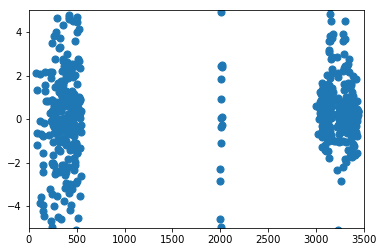

In [16]:
avg_loss=df_dayloss.groupby('station_id', as_index=False)['bike_loss'].mean()
plt.scatter(avg_loss.station_id, avg_loss.bike_loss,s=50)
axes = plt.gca()
axes.set_xlim([0,3500])
axes.set_ylim([-5,5])

In [17]:
small_sta_id=avg_loss[avg_loss.station_id<=2000]
print small_sta_id.describe()
large_sta_id=avg_loss[avg_loss.station_id>2000]
print large_sta_id.describe()

        station_id   bike_loss
count   291.000000  291.000000
mean    372.065292   -0.650924
std     147.551134    5.484967
min      72.000000  -49.677419
25%     290.000000   -1.903226
50%     376.000000    0.032258
75%     459.500000    1.274194
max    2000.000000   19.032258
        station_id   bike_loss
count   322.000000  322.000000
mean   3185.173913    0.605777
std     279.837081    3.272735
min    2001.000000  -11.806452
25%    3108.250000   -0.322581
50%    3238.500000    0.193548
75%    3349.750000    0.838710
max    3440.000000   33.818182


## Linear Regression 

    1. Linear regression for each station(December)
    2. Coff Analysis (Larger coff represents for larger effect of that variable)
    3. Significant test for each independent variable
    4. R^2 & accuracy of Linear Regression Model (When test data coming in)


In [18]:
station_id_set = set(df_dayloss['station_id'])
for i in station_id_set:
    a=df_dayloss[df_dayloss['station_id']==i]
    X=a.ix[:,5:10]
    Y=a.ix[:,4]# Assign features to be X and target to be Y.
    try:
        mdl = LinearRegression().fit(X,Y)
        m = mdl.coef_
        b = mdl.intercept_
        #print 'y={}x+{}'.format(m,b)
    except:
        continue

##  Cross Validation -- Linear Regression

In [20]:
LR_CV_score_set = []
LR_culmilative_set = []
id_set = []
# Count RMSE (Root Mean Squared Error) for every station 
for i in station_id_set:
    a=df_dayloss[df_dayloss['station_id']==i]
    X=a.ix[:,5:11]
    y=a.ix[:,4]
    linearReg = LinearRegression()
    try:
        mean_CV_score = math.sqrt(-(cross_val_score(linearReg, X, y, cv=10, scoring='neg_mean_squared_error').mean()))
        #print 'CV score for station %s is: '%i +str(mean_CV_score)
        LR_CV_score_set.append(mean_CV_score)
        LR_culmilative_set.append(np.mean(LR_CV_score_set))
        id_set.append(i)
    except:
        continue
print 'Mean Score of Cross Validation using Linear Regression is:' + str(np.mean(LR_CV_score_set))
print 'Standard Deviation Score of Cross Validation using Linear Regression is:' + str(np.std(LR_CV_score_set))

Mean Score of Cross Validation using Linear Regression is:7.59309025795
Standard Deviation Score of Cross Validation using Linear Regression is:4.9238952413


## Random Forest

    1. Importance of Each Feature
    2. Accuracy of Random Forest Model

## Cross Validation --- Random Forest

In [21]:
RF_CV_score_set = []
RF_culmilative_set = []
RF_id_set = []
for i in station_id_set:
    a=df_dayloss[df_dayloss['station_id']==i]
    X=a.ix[:,5:11]
    y=a.ix[:,4]
    rf = RandomForestRegressor(n_estimators=30,max_features=4)
    try:
        mean_CV_score = math.sqrt(-(cross_val_score(rf, X, y, cv=10, scoring='neg_mean_squared_error').mean()))
        #print 'CV score for station %s is: '%i +str(mean_CV_score)
        RF_CV_score_set.append(mean_CV_score)
        RF_culmilative_set.append(np.mean(RF_CV_score_set))
        RF_id_set.append(i)
    except:
        continue
print 'Mean Score of Cross Validation using Random Forest is: ' + str(np.mean(RF_CV_score_set))
print 'Standard Deviation Score of Cross Validation using Random Forest is: ' + str(np.std(RF_CV_score_set))

Mean Score of Cross Validation using Random Forest is: 8.42052648536
Standard Deviation Score of Cross Validation using Random Forest is: 5.70263211765


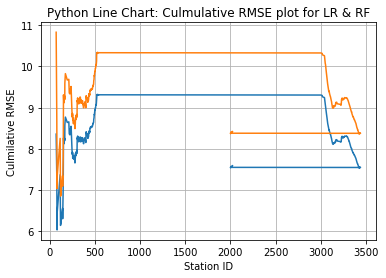

In [22]:
# The total RMASE is counted by average rmse of all stations
# For each model(LR & RF), the culmulative RMSE changes when new station coming in.
from pylab import *
t1 = LR_culmilative_set
t2 = RF_culmilative_set
s = RF_id_set
plot(s, t1)
plot(s,t2)
xlabel('Station ID')
ylabel('Culmilative RMSE')
title('Python Line Chart: Culmulative RMSE plot for LR & RF')
grid(True)
show()

In [ ]:
# grid find best hyperparameter for RF
# from sklearn.model_selection import GridSearchCV

# param_grid = [
#     {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6]},
#     {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
#   ]

# forest_reg = RandomForestRegressor()

# grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
#                            scoring='neg_mean_squared_error')

# box=[]
# for i in station_id_set:
#     a=df_dayloss[df_dayloss['station_id']==i]
#     X=a.ix[:,5:11]
#     y=a.ix[:,4]
#     try:
#         grid_search.fit(X, y)
#         box.append(grid_search.best_params_)
#     except:
#         continue


In [23]:
# Feature Importance using RF(If needed) 
# from sklearn.ensemble import RandomForestRegressor
# for i in station_id_set:
#     a=df_dayloss[df_dayloss['station_id']==i]
#     X=a.ix[:,5:11]
#     Y=a.ix[:,4]# Assign features to be X and target to be Y.
#     rf = RandomForestRegressor()
#     rf.fit(X, Y)
#     print rf.feature_importances_

In [24]:
# Feacture Importance continue
# names = 'wek_index','holiday_idx','High_temp','clear','rain','snow'
# names = np.array(names)
# #sorted(zip(names, rf.feature_importances_),key=lambda x: x[1],reverse=True)
# sorted(zip(names, rlasso.scores_),key=lambda x: x[1],reverse=True)

### training data split

In [405]:
dayloss_72 =df_dayloss[df_dayloss['station_id'] == 79]

In [53]:
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

/Users/linzeyang/anaconda/envs/py2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [54]:
# training data split
X = dayloss_72[['wek_index','holiday_idx','docks']]
y = dayloss_72['bike_loss']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)
#y_train, y_test = cross_validation(y, test_size = 0.25, random_state = 123)
X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()
X_train[1:5]

,wek_index,holiday_idx,docks
1,4,0,34.0
2,5,0,34.0
3,6,0,34.0
4,0,0,34.0


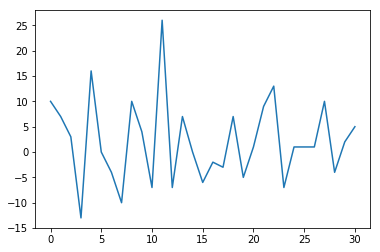

In [55]:
plt.plot(dayloss_72.index, dayloss_72.bike_loss)

### Lasso

In [56]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
import numpy as np

In [57]:
import math
def RMSPE(y, y_pred):
    return math.sqrt( ((1- y_pred / y)**2).mean() )

In [58]:
def test_lasso(alphas):
    scores_lasso = []
    kf = KFold(n_splits=10, random_state = 123)
    
    for alpha in alphas:
        lasso = Lasso(alpha)
        for train, val in kf.split(X_train):
            score_cv = []
            y_pred = lasso.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
            score_cv.append(RMSPE(y_train.values[val], y_pred))
            score = np.mean(score_cv)
        scores_lasso.append(score)
    
    plt.figure(figsize=(14,8))
    cv_lasso = pd.Series(scores_lasso, index = alphas)
    cv_lasso.plot(title = "Validation - Lasso")
    plt.xlabel("alpha")
    plt.ylabel("RMSPE")
    print(cv_lasso.argmin())

/Users/xiaowan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


20.0


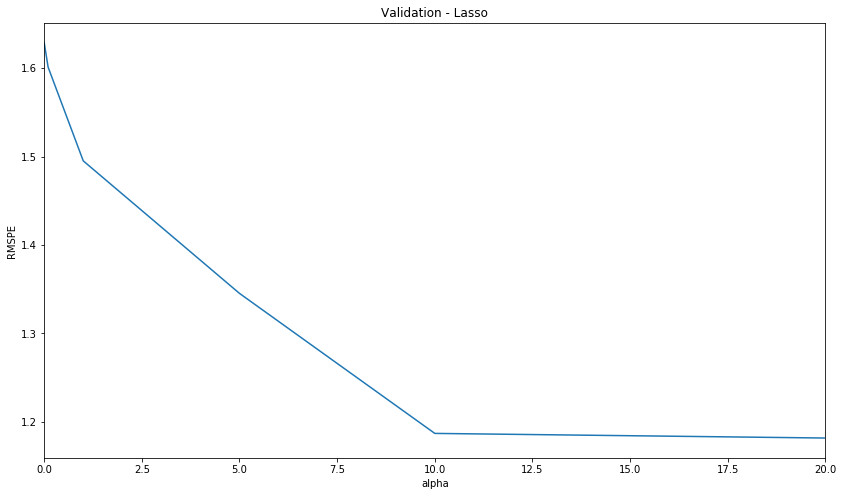

In [75]:
alphas = [1e-4, 1e-3,1e-2, 0.1, 1, 5, 10, 20]
test_lasso(alphas)

/Users/xiaowan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


12


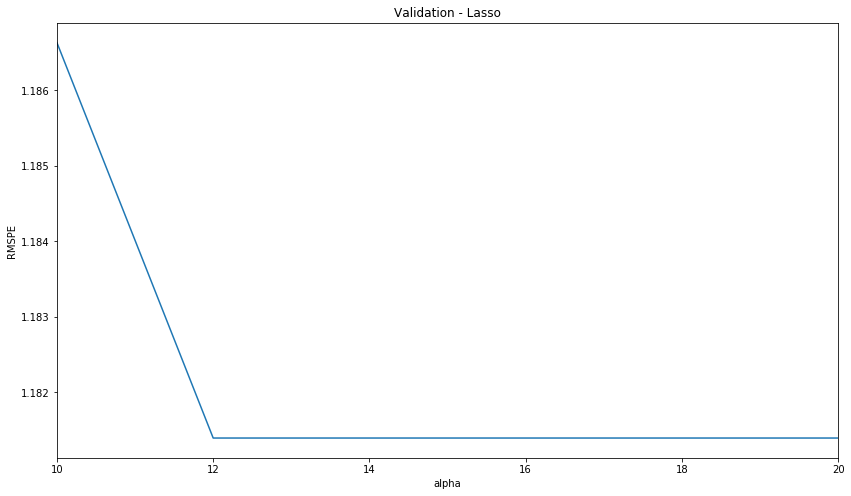

In [76]:
alphas = [10, 12, 14, 18, 20]
test_lasso(alphas)

/Users/xiaowan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


10.5


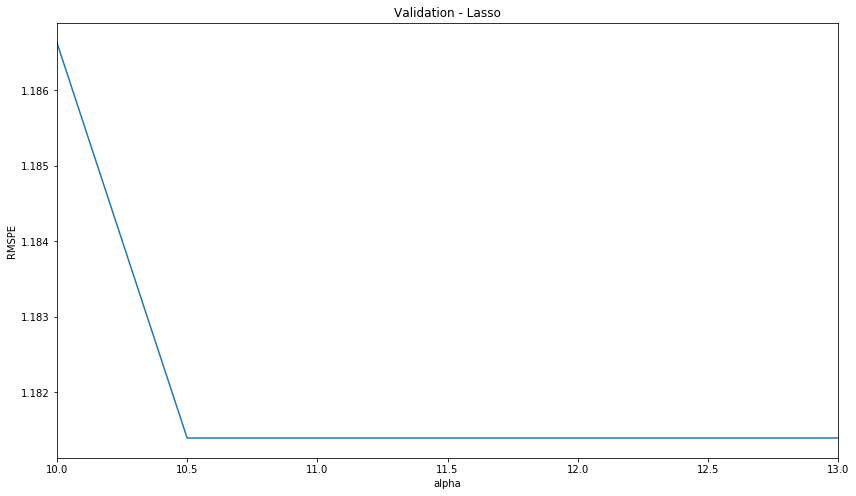

In [77]:
alphas = [10, 10.5, 11, 11.25, 11.5, 11.75, 12, 12.25, 12.5, 13]
test_lasso(alphas)

/Users/xiaowan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


10.2


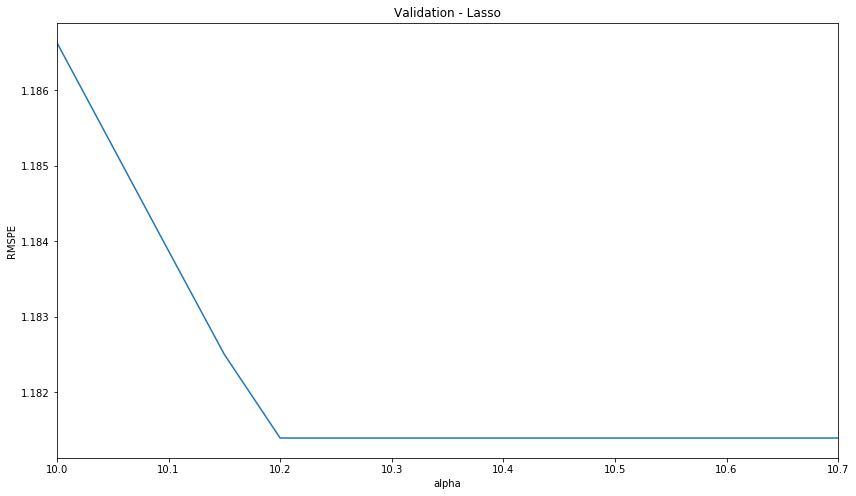

In [78]:
alphas = [10, 10.10,10.15, 10.20, 10.25, 10.30,10.40,10.55,10.7]
test_lasso(alphas)

In [79]:
lasso = Lasso(alpha=10.2)
scores_lasso = []
kf = KFold(n_splits=10, random_state = 123)
    
for alpha in alphas:
    lasso = Lasso(alpha)
    for train, val in kf.split(X_train):
        score_cv = []
        y_pred = lasso.fit(X_train.values[train],y_train.values[train]).predict(X_train.values[val])
        score_cv.append(RMSPE(y_train.values[val], y_pred))
        score = np.mean(score_cv)
    scores_lasso.append(score)

/Users/xiaowan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in divide
  app.launch_new_instance()


In [80]:
# prediction of bike loss of station 72
y_pred

array([ 2.33333333,  2.33333333])